Прогнозирование временного ряда на примере решения задачи прогнозирования стоимости акций компании APPLE

Ключевые пункты:
* учет тренда и сезонности временного ряда стоимости 
* учет дополнительных параметров при прогнозировании - объем, уровни, волны
* учет возможной волатильности временного ряда
* анализ возможных рисков при соверешении операций с ценными бумагами
* использование разработанного инструмента для анализа различных акций и тд.

Методы для предсказания:
* ARIMA и т.д
* Преобразование Фурье
* Нейронные сети 
* Цепи Маркова


План диплома


Todo: 
* логарифмирование исходного ряда
* попробовать SARIMAX с дополнительными параметрами
* нейронные сети для анализа ряда 

# Эксперимент #3. Прогнозирование при помощи рекуррентных нейронных сетей

In [1]:
a = 'None'
if a:
    print(a)
else:
    print('not a')

None


In [7]:
a = None
b = a or "some"

print(a)
print(b)

None
None


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
import yfinance as yf
import warnings

from datetime import datetime
from ta import add_all_ta_features
from ta.utils import dropna
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

import tensorflow as tf

import plotly.graph_objects as go

In [2]:
# pip install tensorflow


     ---------------------------------------- 0.0/266.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/266.3 MB 1.4 MB/s eta 0:03:16
     ---------------------------------------- 0.1/266.3 MB 1.3 MB/s eta 0:03:23
     ---------------------------------------- 0.2/266.3 MB 2.0 MB/s eta 0:02:15
     ---------------------------------------- 0.4/266.3 MB 2.3 MB/s eta 0:01:58
     ---------------------------------------- 0.6/266.3 MB 2.7 MB/s eta 0:01:40
     ---------------------------------------- 0.7/266.3 MB 2.8 MB/s eta 0:01:36
     ---------------------------------------- 1.0/266.3 MB 3.1 MB/s eta 0:01:27
     ---------------------------------------- 1.2/266.3 MB 3.4 MB/s eta 0:01:19
     ---------------------------------------- 1.4/266.3 MB 3.5 MB/s eta 0:01:16
     ---------------------------------------- 1.7/266.3 MB 3.7 MB/s eta 0:01:12
     ---------------------------------------- 1.9/266.3 MB 3.8 MB/s eta 0:01:10
     ---------------------------------------- 

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Получение котировок акций Apple
# data = ek.get_timeseries('AAPL.0', fields='*', 
#                          start_date='2018-10-18 16:00:00', 
#                          end_date='2018-10-18 17:00:00', 
#                          interval='tick')

# data.info()

# #1.0 Загрузка и анализ исходных даных
### #1.1 Загрузка данных и разбиение на train/test

In [4]:
# Часовой график
# apple_df_tmp = yf.download("AAPL", start="2022-01-03", interval='1h') #.to_csv('data/test.csv')
# apple_df_tmp.head()

In [2]:
apple_df = pd.read_csv('data/AAPL_20060101-20230131.csv', parse_dates=["Date"], index_col=["Date"])

# apple_df = yf.download("AAPL", start="2006-01-03", end="2023-01-30")
# apple_df = yf.download("AAPL", start="2006-01-03", interval='1d') #.to_csv('data/test.csv')

apple_df.head()

# apple_df = pd.read_csv('data/test.csv') #, parse_dates=["Date"], index_col=["Date"])

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-01-03,2.585000,2.669643,2.580357,2.669643,2.275651,807234400
2006-01-04,2.683214,2.713571,2.660714,2.677500,2.282349,619603600
2006-01-05,2.672500,2.675000,2.633929,2.656429,2.264388,449422400
2006-01-06,2.687500,2.739286,2.662500,2.725000,2.322838,704457600
2006-01-09,2.740357,2.757143,2.705000,2.716071,2.315227,675040800


#### Логарифмирование ряда - ???

In [10]:
# apple_df['Close'] = np.log(apple_df['Close'])

#### Разбиение на train/test

In [3]:
# Разбиение на тренировочную и тестовую выборки
train_df = apple_df.loc[:'2022-07-29'] #apple_df.iloc[:-3]
test_df = apple_df.loc['2022-08-01':] #apple_df.iloc[-3:]

train_df.shape, test_df.shape

((4172, 6), (126, 6))

##### Разбиение данных (k-fold) - ????
Разбиение может проводится, например, следующим образом: 
30 дней обучение, 5 дней - прогноз 

# #2.0 Составление модели прогнозирования на основе ИНС
### #2.1 Стандартизация данных

In [4]:
train_close_mean = train_df['Close'].mean()
train_close_std = train_df['Close'].std()

print(train_close_mean)
print(train_close_std)

37.45372937248327
42.96689539438329


In [5]:
train_df['Close_stand'] = (train_df['Close'] - train_close_mean) / train_close_std

train_df.head()

C:\Users\b.ostreshko\AppData\Local\Temp\ipykernel_19264\3930516961.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Close_stand'] = (train_df['Close'] - train_close_mean) / train_close_std


,Open,High,Low,Close,Adj Close,Volume,Close_stand
Date,,,,,,,
2006-01-03,2.585000,2.669643,2.580357,2.669643,2.275651,807234400,-0.809555
2006-01-04,2.683214,2.713571,2.660714,2.677500,2.282349,619603600,-0.809373
2006-01-05,2.672500,2.675000,2.633929,2.656429,2.264388,449422400,-0.809863
2006-01-06,2.687500,2.739286,2.662500,2.725000,2.322838,704457600,-0.808267
2006-01-09,2.740357,2.757143,2.705000,2.716071,2.315227,675040800,-0.808475


<AxesSubplot:>

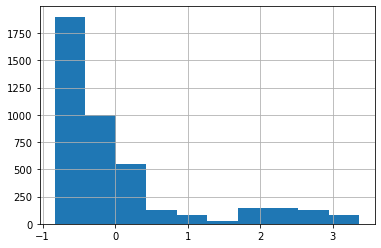

In [20]:
train_df['Close_stand'].hist()

<AxesSubplot:>

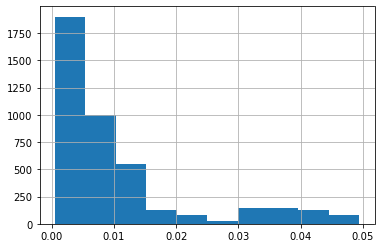

In [18]:
pd.Series(tf.keras.utils.normalize(np.array(train_df['Close']))[0]).hist()

In [16]:
len(tf.keras.utils.normalize(np.array(train_df['Close']))[0])

4172

c:\Users\b.ostreshko\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:>

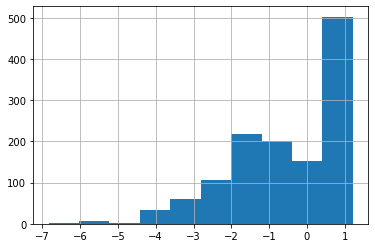

In [21]:
np.log(train_df['Close_stand']).hist()